# Nash Value-Iteration
This tutorial  demonstrates Nash Value-Iteration on a zero-sum strategic (non-extensive) game. 

For the payoff matrix, row player is maximizer, coloumn player is minimizer.

Reference: 
* https://arxiv.org/abs/2006.12007
* http://proceedings.mlr.press/v139/liu21z.html

Status: TODO

## Get Arbitrary MDP Environment

Reward matrices: $[t, s, (a_1, a_2), s'] -> r$

Transition probability matrices: $[t, s, (a_1, a_2), s'] -> p$

In [1]:
import sys
sys.path.append("../..")
from mars.env.mdp import ArbitraryMDP, MDPWrapper
import numpy as np

num_states = 3
num_actions_per_player = 3
num_trans = 3

env = MDPWrapper(ArbitraryMDP(num_states=num_states, num_actions_per_player=num_actions_per_player, num_trans=num_trans))
trans_matrices = env.env.trans_prob_matrices # shape: [dim_transition, dim_state, dim_action (p1*p2), dim_state]
reward_matrices = env.env.trans_prob_matrices # shape: [dim_transition, dim_state, dim_action (p1*p2), dim_state]

oracle_nash_v, oracle_nash_q, _ = env.NEsolver(verbose=False)
oracle_v_star = oracle_nash_v[0]

oracle_v_star = np.mean(oracle_v_star, axis=0)
print(env.observation_space, env.action_space)
# env.render()
obs = env.reset()
print(obs)
done = False
while not np.any(done):
    obs, r, done, _ = env.step([1,0])
    print(obs, r, done)
print('orcale v star: ', oracle_v_star)


Box(0.0, 12.0, (1,), float32) Discrete(3)
[[0], [0]]
[[5], [5]] [0.5610583525729109, -0.5610583525729109] [False, False]
[[6], [6]] [-0.7261994566288021, 0.7261994566288021] [False, False]
[[9], [9]] [-0.8460871060267345, 0.8460871060267345] [True, True]
orcale v star:  -0.29607107415447115


/home/quantumiracle/anaconda3/envs/res/lib/python3.6/site-packages/ecos/ecos.py:26: UserWarning: Converting G to a CSC matrix; may take a while.
  warn("Converting G to a CSC matrix; may take a while.")
/home/quantumiracle/anaconda3/envs/res/lib/python3.6/site-packages/ecos/ecos.py:29: UserWarning: Converting A to a CSC matrix; may take a while.
  warn("Converting A to a CSC matrix; may take a while.")


## Nash Value-Iteration

In [2]:
from mars.equilibrium_solver import NashEquilibriumECOSSolver, NashEquilibriumMWUSolver, NashEquilibriumParallelMWUSolver
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)

def get_matrix(q_tab, state):
    return q_tab[state]

def get_nash_value(payoff, solver, solver_itr):
    if solver == 'ecos':
        ne, _ = NashEquilibriumECOSSolver(payoff)
        ne_value = ne[0]@payoff@ne[1].T
    elif solver == 'mwu':
        ne, ne_value = NashEquilibriumMWUSolver(payoff, Itr=solver_itr)
    else:
        raise NotImplementedError

    return ne_value

def get_random_action(dim):
    return np.random.randint(0, dim, size=2)

def get_action_from_nash(q_tab, state, solver, solver_itr):
    """ sample action from current 'nash' strategies. """
    payoff = get_matrix(q_tab, state)
    if solver == 'ecos':
        ne, _ = NashEquilibriumECOSSolver(payoff)
    elif solver == 'mwu':
        ne, ne_value = NashEquilibriumMWUSolver(payoff, Itr=solver_itr)
    else:
        raise NotImplementedError
        
    actions = []
    for dist in ne:
        sample_hist = np.random.multinomial(1, dist)
        a = np.where(sample_hist>0)
        actions.append(a[0][0])
    return actions

def compare_with_oracle(nash_q, oracle_nash_q):
    # nash_q_ = nash_q[:-num_states]  # no nash value for last-step states
    nash_q_ = nash_q
    nash_q_ = nash_q_.reshape(num_trans, num_states, num_actions_per_player, num_actions_per_player)

    mse = np.mean((nash_q_ - np.array(oracle_nash_q))**2)
    return mse

def best_response_value(trans_prob_matrices, reward_matrices, learned_q, num_actions):
    """
    Formulas for calculating best response values:
    1. Nash strategies: (\pi_a^*, \pi_b^*) = \min \max Q(s,a,b), 
        where Q(s,a,b) = r(s,a,b) + \gamma \min \max Q(s',a',b') (this is the definition of Nash Q-value);
    2. Best response (of max player) value: Br V(s) = \min_b \pi(s,a) Q(s,a,b)
    """

    Br_v = []
    Br_q = []
    Nash_strategies = []
    for tm, rm, qm in zip(trans_prob_matrices[::-1], reward_matrices[::-1], learned_q[::-1]): # inverse enumerate 
        if len(Br_v) > 0:
            rm = np.array(rm)+np.array(Br_v[-1])  # broadcast sum on rm's last dim, last one in Nash_v is for the next state
        br_q_values = np.einsum("ijk,ijk->ij", tm, rm)  # transition prob * reward for the last dimension in (state, action, next_state)
        br_q_values = br_q_values.reshape(-1, num_actions, num_actions) # action list to matrix
        Br_q.append(br_q_values)
        br_values = []
        ne_strategies = []
        for q, br_q in zip(qm, br_q_values):
            ne, _ = NashEquilibriumECOSSolver(q)
            ne_strategies.append(ne)
            br_value = np.min(ne[0]@br_q)  # best response againt "Nash" strategy of first player
            br_values.append(br_value)  # each value is a Nash equilibrium value on one state
        Br_v.append(br_values)  # (trans, state)
        Nash_strategies.append(ne_strategies)
    Br_v = Br_v[::-1]  # (#trans, #states)
    Br_q = Br_q[::-1]
    Nash_strategies = Nash_strategies[::-1]

    avg_init_br_v = -np.mean(Br_v[0])  # average best response value of initial states; minus for changing the perspective from first to second player (exploiter)
    return avg_init_br_v

In [7]:
def nash_vi_deprecated(env, gamma = 1, itr = 20000, epsilon = 0.5, update_interval = 200, solver='ecos', solver_itr=None):
    tau = np.sqrt(np.log(num_actions_per_player)/itr)

    # initialize Nash Q table 
    nash_q_tab = np.ones((num_trans*num_states, num_actions_per_player, num_actions_per_player))  # there is (num_trans+1) state space
    print(nash_q_tab.shape)
    print(np.array(oracle_nash_q).shape)

    update_tab = np.zeros((num_trans*num_states, num_actions_per_player, num_actions_per_player)) # a buffer recording updates
    entry_cnts = np.zeros((num_trans*num_states, num_actions_per_player, num_actions_per_player))  # counting the updates in each entry

    mse_list = []
    brv_list = []
    all_itr = 0
    for i in range(itr):
        brv = best_response_value(env.env.trans_prob_matrices, env.env.reward_matrices, \
            nash_q_tab.reshape(num_trans, num_states, num_actions_per_player, num_actions_per_player), num_actions_per_player)
        mse = compare_with_oracle(nash_q_tab, oracle_nash_q)
        if i % 100 == 0:
            print(f"process: {i/itr*100}%, mse: {mse}, brv: {brv}")
        mse_list.append(mse)
        brv_list.append(brv)
        obs = env.reset()
        done = False
        while not np.any(done):
            if np.random.random() > epsilon:
                action = get_action_from_nash(nash_q_tab, obs[0][0], solver, solver_itr)
            else:
                action = get_random_action(num_actions_per_player)
            next_obs, r, done, _ = env.step(action)

            if done[0]:  # there is no action and reward for terminal state, so cannot get nash value for its next state
                nash_target = r[0]
            else:
                next_obs_payoff = get_matrix(nash_q_tab, next_obs[0][0])
                next_obs_nash_value = get_nash_value(next_obs_payoff, solver, solver_itr)
                nash_target = r[0]+gamma*next_obs_nash_value*(1-float(done[0]))  # from agent 0's perspective
            
            all_itr += 1

            # acculmulate updates
            update_tab[obs[0][0], action[0], action[1]] += nash_target
            entry_cnts[obs[0][0], action[0], action[1]] += 1

            # not incremental update, but update with the buffer all at once with the average
            if all_itr % update_interval == 0:
                for j in range(num_trans*num_states):
                    for m in range(num_actions_per_player):
                        for n in range(num_actions_per_player):
                            if entry_cnts[j, m, n]>0:
                                nash_q_tab[j, m, n] = update_tab[j, m, n]/float(entry_cnts[j, m, n])
                # clear buffer after update; found this hurt performance a lot; but it should be cleared, otherwise use old Q for nash_target, which is wrong
                update_tab = np.zeros((num_trans*num_states, num_actions_per_player, num_actions_per_player)) # a buffer recording updates
                entry_cnts = np.zeros((num_trans*num_states, num_actions_per_player, num_actions_per_player))  # counting the updates in each entry

            # nash_q_tab[obs[0][0], action[0], action[1]] = tau*nash_target + (1-tau)*nash_q_tab[obs[0][0], action[0], action[1]]
            obs = next_obs
    print(nash_q_tab)
    return mse_list, brv_list


The above version doesn't work because it stores the updates rather than transition samples for tabular update, and the udpates stored can no longer be used anymore once the nash-Q table is updated, so the buffer storing it has to be cleared. Therefore the sample size in the buffer cannot be large, so this cannot give a very accurate result although correct.

In [3]:
def nash_vi(env, gamma = 1, itr = 20000, epsilon = 0.5, update_interval = 200, solver='ecos', solver_itr=None):
    tau = np.sqrt(np.log(num_actions_per_player)/itr)

    # initialize Nash Q table 
    nash_q_tab = np.ones((num_trans*num_states, num_actions_per_player, num_actions_per_player))  # there is (num_trans+1) state space
    print(nash_q_tab.shape)
    print(np.array(oracle_nash_q).shape)

    transition_buffer = [[[[] for _ in range(num_actions_per_player)] for _ in range(num_actions_per_player)] for _ in range(num_trans*num_states)]  # (num_trans*num_states, num_actions_per_player, num_actions_per_player, *)

    mse_list = []
    brv_list = []
    all_itr = 0
    for i in range(itr):
        brv = best_response_value(env.env.trans_prob_matrices, env.env.reward_matrices, \
            nash_q_tab.reshape(num_trans, num_states, num_actions_per_player, num_actions_per_player), num_actions_per_player)
        mse = compare_with_oracle(nash_q_tab, oracle_nash_q)
        if i % 100 == 0:
            print(f"process: {i/itr*100}%, mse: {mse}, brv: {brv}")
        mse_list.append(mse)
        brv_list.append(brv)
        obs = env.reset()
        done = False
        while not np.any(done):
            if np.random.random() > epsilon:
                action = get_action_from_nash(nash_q_tab, obs[0][0], solver, solver_itr)
            else:
                action = get_random_action(num_actions_per_player)
            next_obs, r, done, _ = env.step(action)
            
            all_itr += 1

            # store transition data rather than store update: this is critical!
            transition = (r[0], done[0], next_obs[0][0])
            transition_buffer[obs[0][0]][action[0]][action[1]].append(transition)

            # not incremental update, but update with the buffer all at once with the average
            if all_itr % update_interval == 0:
                for j in range(num_trans*num_states):
                    for m in range(num_actions_per_player):
                        for n in range(num_actions_per_player):
                            updates = []
                            if len(transition_buffer[j][m][n]) > 0:
                                for r, d, s_ in transition_buffer[j][m][n]:
                                    if d:  # this case needs to handle individually for tabular case
                                        nash_target = r
                                    else:
                                        next_obs_payoff = get_matrix(nash_q_tab, s_)
                                        next_obs_nash_value = get_nash_value(next_obs_payoff, solver, solver_itr)
                                        nash_target = r+gamma*next_obs_nash_value*(1-float(d))
                                    updates.append(nash_target)  # average update overall all samples with the same (s,a,b)
                                nash_q_tab[j, m, n] = np.mean(updates)  # update with the average

            obs = next_obs
    print(nash_q_tab)
    return mse_list, brv_list


(10, 2, 2)
(5, 2, 2, 2)
process: 0.0%, mse: 0.6115519799383214, brv: 0.5039016453327498


/home/quantumiracle/anaconda3/envs/x/lib/python3.7/site-packages/ecos/ecos.py:26: UserWarning: Converting G to a CSC matrix; may take a while.
  warn("Converting G to a CSC matrix; may take a while.")
/home/quantumiracle/anaconda3/envs/x/lib/python3.7/site-packages/ecos/ecos.py:29: UserWarning: Converting A to a CSC matrix; may take a while.
  warn("Converting A to a CSC matrix; may take a while.")


process: 1.0%, mse: 0.28071004981052894, brv: -0.19020803983758652
process: 2.0%, mse: 0.011409969429225056, brv: -0.3412715536637592
process: 3.0%, mse: 0.009471589331146602, brv: -0.3547592858616134
process: 4.0%, mse: 0.009241934295871982, brv: -0.3663575844147073
process: 5.0%, mse: 0.005902758758876124, brv: -0.3694520588369513
process: 6.0%, mse: 0.004499368510210527, brv: -0.3844232013916313
process: 7.000000000000001%, mse: 0.002585059900253714, brv: -0.39112982474324043
process: 8.0%, mse: 0.002666826620889781, brv: -0.3909104221136699
process: 9.0%, mse: 0.002900193813631877, brv: -0.3774164730878365
process: 10.0%, mse: 0.002611074426921636, brv: -0.3798225663457159
process: 11.0%, mse: 0.002390721579938291, brv: -0.38331803056834446
process: 12.0%, mse: 0.0022987697088318803, brv: -0.38300438417084726
process: 13.0%, mse: 0.0019771033887227966, brv: -0.38159629652719756
process: 14.000000000000002%, mse: 0.001993533737253643, brv: -0.38595246917942744
process: 15.0%, mse: 0

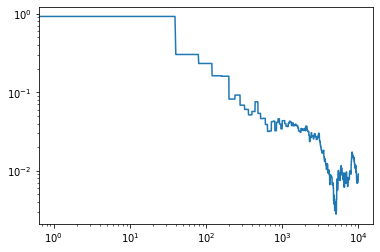

In [37]:
mse_list, brv_list = nash_vi(env, itr=10000, epsilon = 1.0)
print(brv_list[-10:])
# plt.plot(mse_list, label='mse')
plt.plot(brv_list+oracle_v_star, label='brv')
plt.xscale('log')
plt.yscale('log')


In [12]:
print(oracle_nash_q)

[array([[[ 0.37287893,  0.66221666],
        [ 0.62509796, -0.597164  ]],

       [[ 1.02921984,  0.42545672],
        [ 0.91332468,  0.19511151]]]), array([[[ 0.14918102,  1.07600066],
        [ 0.14345223, -0.20942076]],

       [[ 0.44815072, -0.1061747 ],
        [ 0.27833386,  0.34702243]]]), array([[[ 0.27484548,  1.52583089],
        [ 0.56948272,  0.12821649]],

       [[ 0.43220189,  0.4105958 ],
        [ 0.65141654, -0.05850959]]]), array([[[ 0.72093156,  0.6961715 ],
        [ 0.21799965,  0.59343631]],

       [[ 0.47390879,  0.70001279],
        [ 0.74305682, -0.55837045]]]), array([[[ 0.12049038,  0.16868533],
        [ 0.06934144,  0.13694394]],

       [[-0.03579362,  0.13697264],
        [ 0.39352923, -0.46514892]]])]


(9, 3, 3)
(3, 3, 3, 3)
process: 0.0%, mse: 1.3916078832294372, brv: 0.7608750685387423
process: 0.5%, mse: 0.8233327835605193, brv: 0.7707971319690743
process: 1.0%, mse: 0.2971282088626439, brv: 0.4224633479307809
process: 1.5%, mse: 0.20506895288018143, brv: 0.5067296001483031
process: 2.0%, mse: 0.1175862806232758, brv: 0.44997890176751865
process: 2.5%, mse: 0.09922780904941239, brv: 0.4248163009558233
process: 3.0%, mse: 0.07329853972068458, brv: 0.4180863053396882
process: 3.5000000000000004%, mse: 0.0629013929854883, brv: 0.4171395537739284
process: 4.0%, mse: 0.04987987953243443, brv: 0.4265797281714949
process: 4.5%, mse: 0.04363683933465685, brv: 0.4116554370721707
process: 5.0%, mse: 0.03764880599084724, brv: 0.40817194607338897
process: 5.5%, mse: 0.03327872140929585, brv: 0.40415683716897016
process: 6.0%, mse: 0.025548998071419735, brv: 0.3826878266660692
process: 6.5%, mse: 0.02280611199778504, brv: 0.39961874188903357
process: 7.000000000000001%, mse: 0.0199284762947736

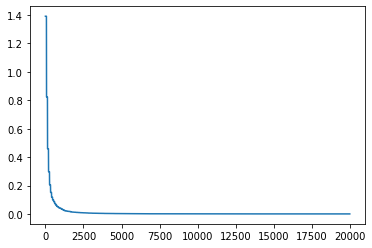

In [23]:
mse_list, _ = nash_vi(env, epsilon = 0.5, solver='mwu', solver_itr=100)
plt.plot(mse_list)

Compare Nash VI using different values of $\epsilon$-greedy.

In [ ]:
mses = []
Itr = 50000
mses.append(nash_vi(env, itr=Itr, epsilon = 0.5)[0])
mses.append(nash_vi(env, itr=Itr, epsilon = 1.)[0]) # epsilon=1, purely random action
mses.append(nash_vi(env, itr=Itr, epsilon = 0.5, solver='mwu', solver_itr=10)[0])
mses.append(nash_vi(env, itr=Itr, epsilon = 1., solver='mwu', solver_itr=10)[0])
mses.append(nash_vi(env, itr=Itr, epsilon = 0.5, solver='mwu', solver_itr=100)[0])
mses.append(nash_vi(env, itr=Itr, epsilon = 1., solver='mwu', solver_itr=100)[0])

save_path = '../../data/compare_nash_vi.npy'
np.save(save_path, np.array(mses))

In [ ]:
labels = ['Ecos-epsilon=0.5', 'Ecos-epsilon=1.0', 'MWU-epsilon=0.5;itr=10', \
    'MWU-epsilon=1.0;itr=10', 'MWU-epsilon=0.5;itr=100', 'MWU-epsilon=1.0;itr=100' ]

plt.figure(figsize=(8, 6), dpi=300)

save_path = '../../data/compare_nash_vi.npy'
mses = np.load(save_path, allow_pickle=True)

for mse, l in zip(mses, labels):
    plt.plot(mse, label=l)

plt.xlabel('Training Episodes')
plt.ylabel('MSE')
plt.title('Comparison of Nash-VI')
plt.yscale('log')
plt.legend()
plt.grid()
plt.savefig('../../data/figs/compare_nash_vi.png')
plt.show()

In [ ]:
# comparison plot across 3 runs

def smooth(y, radius=1000, mode='two_sided'):
    if len(y) < 2*radius+1:
        return np.ones_like(y) * y.mean()
    elif mode == 'two_sided':
        convkernel = np.ones(2 * radius+1)
        return np.convolve(y, convkernel, mode='same') / \
               np.convolve(np.ones_like(y), convkernel, mode='same')
    elif mode == 'causal':
        convkernel = np.ones(radius)
        out = np.convolve(y, convkernel,mode='full') / \
              np.convolve(np.ones_like(y), convkernel, mode='full')
        return out[:-radius+1]


def plot_with_fill(x, data, label, color=None):
    y_m=np.mean(data, axis=0)
    y_std=np.std(data, axis=0)
    y_upper=y_m+y_std
    y_lower=y_m-y_std
    if color is not None:
        plt.fill_between(
        x, list(y_lower), list(y_upper), interpolate=True, facecolor=color, linewidth=0.0, alpha=0.3
    )   
    else:
        plt.fill_between(
        x, list(y_lower), list(y_upper), interpolate=True, linewidth=0.0, alpha=0.3
    )     
    plt.plot(x, list(smooth(y_m)), color=color, label=label)


labels = ['Ecos-epsilon=0.5', 'Ecos-epsilon=1.0', 'MWU-epsilon=0.5;itr=10', \
    'MWU-epsilon=1.0;itr=10', 'MWU-epsilon=0.5;itr=100', 'MWU-epsilon=1.0;itr=100' ]

plt.figure(figsize=(8, 4), dpi=300)

all_data = []
for i in range(1,4):
    save_path = f'../../data/compare_nash_vi{i}.npy'
    mses = np.load(save_path, allow_pickle=True)
    all_data.append(mses)

all_data = np.array(all_data)
print(all_data.shape) 
all_data = np.swapaxes(all_data, 0, 1)
print(all_data.shape) 
x = np.arange(all_data.shape[-1])
for y, l in zip(all_data, labels):
    plot_with_fill(x, y, label=l)

plt.xlabel('Training Episodes')
plt.ylabel('MSE')
plt.title('Comparison of Nash-VI')
plt.yscale('log')
plt.legend()
plt.grid()
plt.savefig('../../data/figs/compare_nash_vi_multiple.png')
plt.show()


In [5]:
tests = 3
Itr = 10000

for i in range(tests):
    brvs = []
    mses = []

    mse, brv =  nash_vi(env, itr=Itr, epsilon = 0.5)
    brvs.append(brv)
    mses.append(mse)
    mse, brv = nash_vi(env, itr=Itr, epsilon = 1.)
    brvs.append(brv)
    mses.append(mse)
    mse, brv = nash_vi(env, itr=Itr, epsilon = 0.5, solver='mwu', solver_itr=10)
    brvs.append(brv)
    mses.append(mse)
    mse, brv = nash_vi(env, itr=Itr, epsilon = 1., solver='mwu', solver_itr=10)
    brvs.append(brv)
    mses.append(mse)
    mse, brv = nash_vi(env, itr=Itr, epsilon = 0.5, solver='mwu', solver_itr=100)
    brvs.append(brv)
    mses.append(mse)
    mse, brv =nash_vi(env, itr=Itr, epsilon = 1., solver='mwu', solver_itr=100)
    brvs.append(brv)
    mses.append(mse)

    save_path = f'../../data/compare_nash_vi_brv-{i}.npy'
    np.save(save_path, np.array(brvs))
    save_path = f'../../data/compare_nash_vi_mse-{i}.npy'
    np.save(save_path, np.array(mses))

(9, 3, 3)
(3, 3, 3, 3)
process: 0.0%, mse: 1.3916078832294372, brv: 0.7608750685387423
process: 1.0%, mse: 0.8714994662765148, brv: 0.6921372538757226
process: 2.0%, mse: 0.034278316826301995, brv: 0.575067007993699
process: 3.0%, mse: 0.027599075876282696, brv: 0.5917616580680758
process: 4.0%, mse: 0.021732414137458952, brv: 0.5714270055464481
process: 5.0%, mse: 0.015905728958153394, brv: 0.4962213833317259
process: 6.0%, mse: 0.012780766218732132, brv: 0.46924608246383576
process: 7.000000000000001%, mse: 0.012494770796967189, brv: 0.4065824845936354
process: 8.0%, mse: 0.009019627943811044, brv: 0.4050281014587473
process: 9.0%, mse: 0.008344348902395146, brv: 0.402172091032714
process: 10.0%, mse: 0.006315820463026735, brv: 0.3795147726099186
process: 11.0%, mse: 0.006345132958008237, brv: 0.38305805179301533
process: 12.0%, mse: 0.005677624366207993, brv: 0.366723182766352
process: 13.0%, mse: 0.005499073087571802, brv: 0.36046696417157725
process: 14.000000000000002%, mse: 0.00

(3, 6, 10000)
(6, 3, 10000)


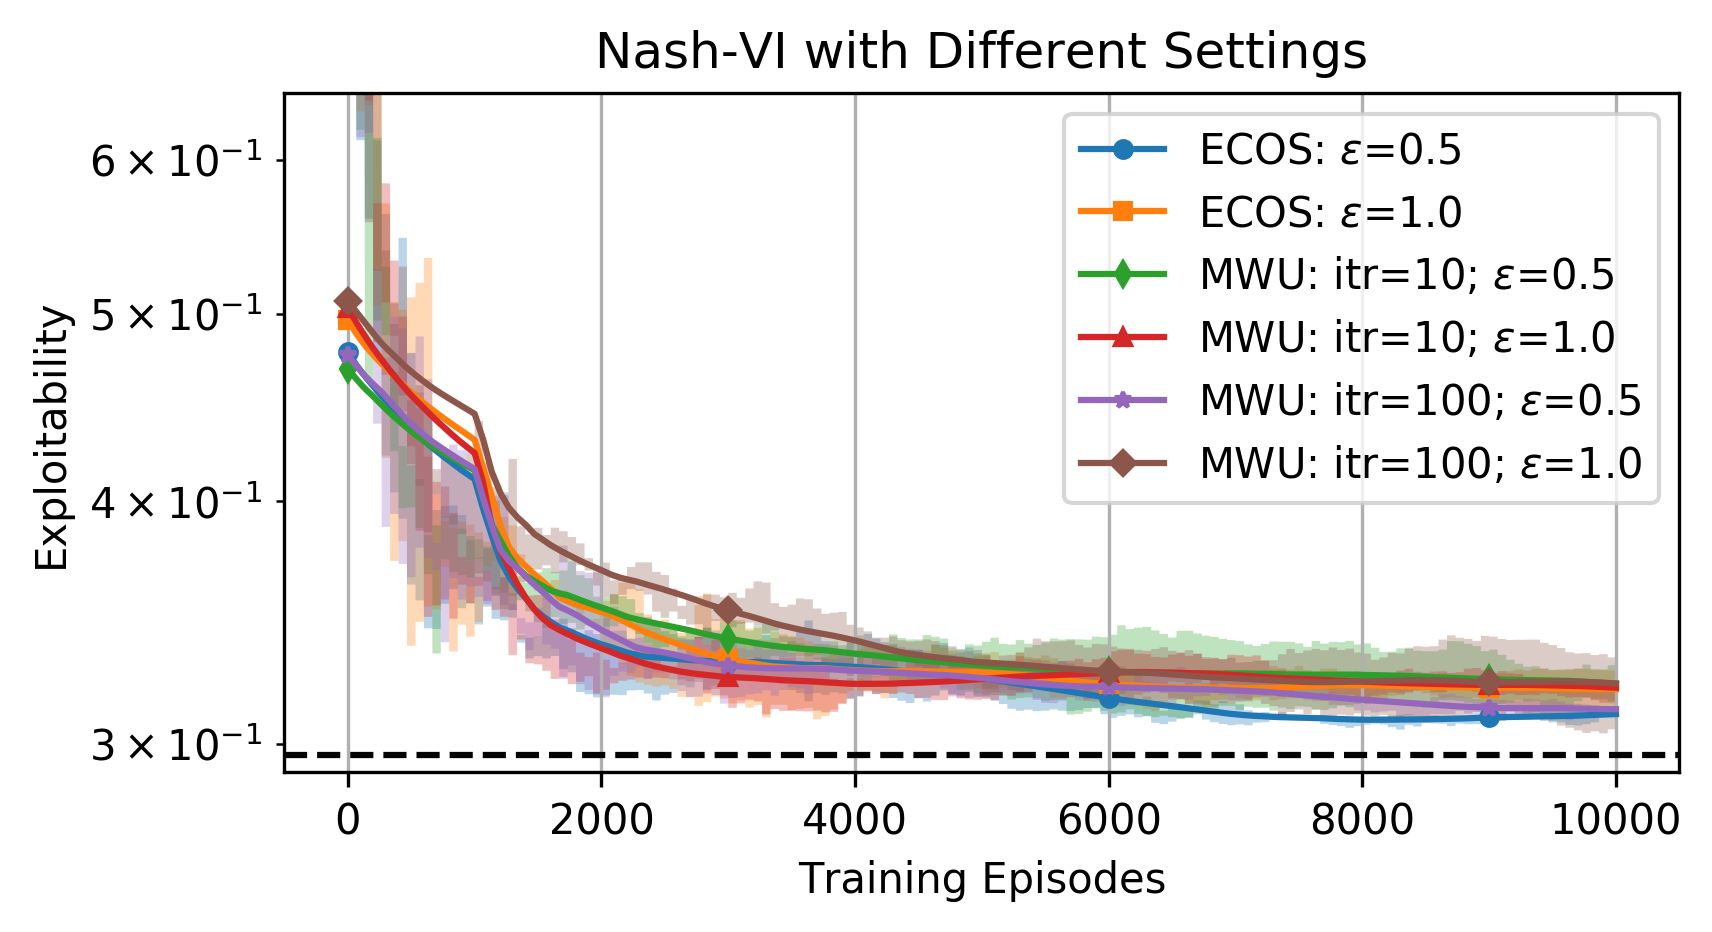

In [6]:
# comparison plot across 3 runs

def smooth(y, radius=1000, mode='two_sided'):
    if len(y) < 2*radius+1:
        return np.ones_like(y) * y.mean()
    elif mode == 'two_sided':
        convkernel = np.ones(2 * radius+1)
        return np.convolve(y, convkernel, mode='same') / \
               np.convolve(np.ones_like(y), convkernel, mode='same')
    elif mode == 'causal':
        convkernel = np.ones(radius)
        out = np.convolve(y, convkernel,mode='full') / \
              np.convolve(np.ones_like(y), convkernel, mode='full')
        return out[:-radius+1]


def plot_with_fill(x, data, label, marker, color=None):
    y_m=np.mean(data, axis=0)
    y_std=np.std(data, axis=0)
    y_upper=y_m+y_std
    y_lower=y_m-y_std
    if color is not None:
        plt.fill_between(
        x, list(y_lower), list(y_upper), interpolate=True, facecolor=color, linewidth=0.0, alpha=0.3
    )   
    else:
        plt.fill_between(
        x, list(y_lower), list(y_upper), interpolate=True, linewidth=0.0, alpha=0.3
    )     
    plt.plot(x, list(smooth(y_m)), color=color, label=label, marker=marker, markevery=3000, markersize=4)


labels = [r'ECOS: $\epsilon$=0.5', r'ECOS: $\epsilon$=1.0', r'MWU: itr=10; $\epsilon$=0.5', \
    r'MWU: itr=10; $\epsilon$=1.0', r'MWU: itr=100; $\epsilon$=0.5', r'MWU: itr=100; $\epsilon$=1.0' ]
markers = ['o', 's', 'd', '^', '*', 'D']

plt.figure(figsize=(6, 3), dpi=300)

all_data = []
for i in range(3):
    save_path = f'../../data/compare_nash_vi_brv-{i}.npy'
    mses = np.load(save_path, allow_pickle=True)
    all_data.append(mses)

all_data = np.array(all_data)
print(all_data.shape) 
all_data = np.swapaxes(all_data, 0, 1)
print(all_data.shape) 

x = np.arange(all_data.shape[-1])
for y, l, m in zip(all_data, labels, markers):
    plot_with_fill(x, y, label=l, marker=m)

plt.axhline(y=0.296, color='black', linestyle='--')
plt.xlabel('Training Episodes')
plt.ylabel('Exploitability')
plt.title('Nash-VI with Different Settings')
plt.yscale('log')
plt.ylim(0.29, 0.65)  # for better view
plt.legend()
plt.grid()
plt.savefig('../../data/figs/compare_nash_vi_multiple_brv.png', bbox_inches='tight')
plt.show()


(3, 6, 10000)
(6, 3, 10000)
(5, 3, 10000)


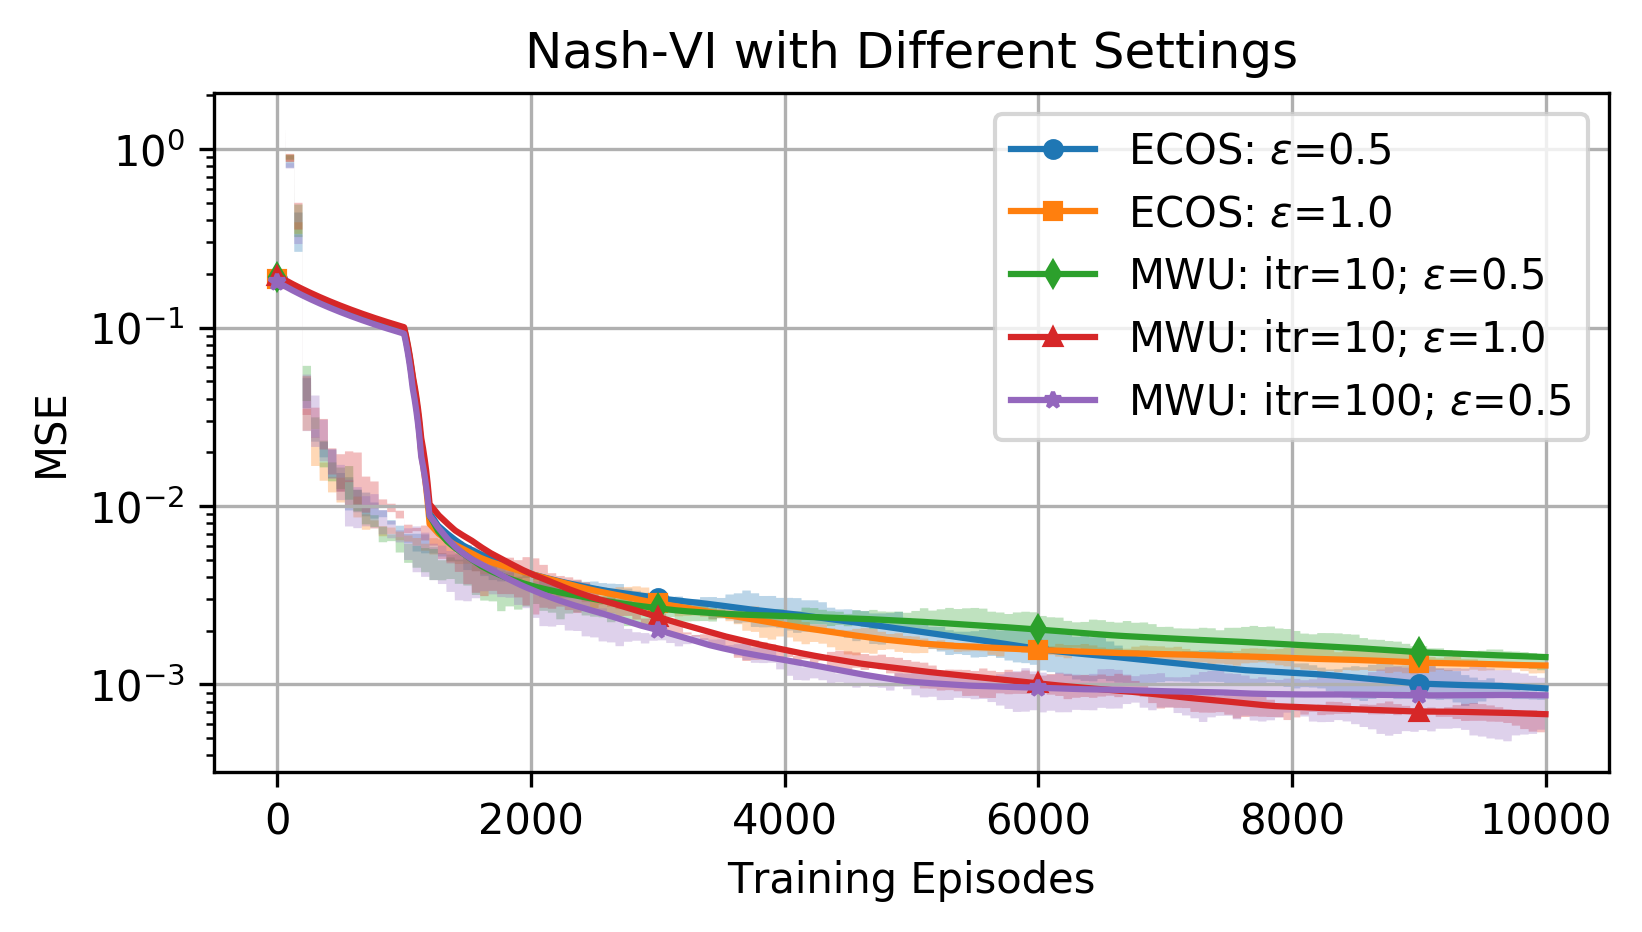

In [7]:
# comparison plot across 3 runs

labels = [r'ECOS: $\epsilon$=0.5', r'ECOS: $\epsilon$=1.0', r'MWU: itr=10; $\epsilon$=0.5', \
    r'MWU: itr=10; $\epsilon$=1.0', r'MWU: itr=100; $\epsilon$=0.5', r'MWU: itr=100; $\epsilon$=1.0' ]

plt.figure(figsize=(6, 3), dpi=300)

all_data = []
for i in range(3):
    save_path = f'../../data/compare_nash_vi_mse-{i}.npy'
    mses = np.load(save_path, allow_pickle=True)
    all_data.append(mses)

all_data = np.array(all_data)
print(all_data.shape) 
all_data = np.swapaxes(all_data, 0, 1)
print(all_data.shape) 
all_data = np.concatenate((all_data[:1], all_data[2:]))
print(all_data.shape) 

x = np.arange(all_data.shape[-1])
for y, l, m in zip(all_data, labels, markers):
    plot_with_fill(x, y, label=l, marker=m)

plt.xlabel('Training Episodes')
plt.ylabel('MSE')
plt.title('Nash-VI with Different Settings')
plt.yscale('log')
plt.legend()
plt.grid()
plt.savefig('../../data/figs/compare_nash_vi_multiple_mse.png', bbox_inches='tight')
plt.show()
